# Part 1: Geostrophic balance
ECCO code: Andrew Delman, updated 2024-04-10.

PO in-class activity: Donata Giglio, October 2024

## Learning objectives

* Estimating the two terms in the geostrophic balance
* Comparing the two terms in the geostrophic balance (using normalized difference) to assess the latitude and depth dependence of geostrophic balance
* Describing where the geostrophic balance explains the ocean flow well and where it does not
* Estimating geostrophic velocities
  
Also, if you look carefully at the code (not needed for the class), by the end of the activity, you will be able to:

* Plot ECCO fields on a single tile
* Carry out spatial differencing and interpolation on the ECCO native model grid
* Apply masks in 2-D spatial plots
* Use the ```ecco_v4_py``` package to plot global maps of ECCO fields

## Introduction

### Conservation of momentum

Geostrophic balance originates from the conservation of momentum, as expressed by the momentum equation:

$$
\frac{D\bf{u}}{Dt} = -\frac{1}{\rho}{\nabla}p + {\nu}{\nabla^2}\bf{u} + \bf{F_b}
$$

following roughly the notation used in Kundu and Cohen (2008) and Vallis (2006). This equation is a simplification of the Navier-Stokes equation for an incompressible fluid. The material derivative $D/Dt \equiv \partial{}/\partial{t} + {\bf{u}}\cdot\nabla$ is the derivative in time *following a fluid parcel*. The symbol $\nu \equiv \mu/\rho$ indicates the kinematic viscosity, and $F_b$ represents body forces (real or apparent) exerted on the fluid.

The equation above applies to any incompressible fluid, even the water in a fish tank or swimming pool. However, the body forces $\bf{F_b}$ are dependent upon the environment of the fluid and the scales being considered. In a physical oceanography context, three forces that are typically very important are (a) gravity, (b) the Coriolis force from rotation of the earth, and (c) friction from surface winds or topography. So the equation above can be rewritten as

$$
\frac{\partial{\bf{u}}}{\partial{t}} + {\bf{u}}\cdot\nabla{\bf{u}} = -\frac{1}{\rho}{\nabla}p + {\nu}{\nabla^2}{\bf{u}} + g\bf{\hat{k}} - 2{\bf{\Omega}}\times{\bf{u}} + \bf{F_f}
$$

Of those last three terms: 
1. Gravity $g\bf{\hat{k}}$ effectively only applies to vertical momentum, and can be neglected in the horizontal momentum equations
1. The Coriolis force $-2{\bf{\Omega}}\times{\bf{u}}$ can be approximated by its vertical component, $2{\Omega}\sin\theta(v{\bf{\hat{i}}} - u{\bf{\hat{j}}})$ where $\Omega$ is the rotation rate of Earth in radians and $\theta$ is latitude
1. Friction $\bf{F_f}$ from wind and topography is negligible in the ocean interior.

To simplify, $f$ is defined as $f \equiv 2{\Omega}\sin\theta$. So using subscript notation for derivatives ($u_t$ is the derivative of $u$ with respect to $t$) the two horizontal components of momentum conservation are:

$$
u_t + {\bf{u}}\cdot\nabla{u} = -\frac{1}{\rho}{p_x} + {\nu}{\nabla^2}u + fv
$$

$$
v_t + {\bf{u}}\cdot\nabla{v} = -\frac{1}{\rho}{p_y} + {\nu}{\nabla^2}v - fu
$$

### Geostrophic balance

The two horizontal momentum equations still have a number of terms, but in the global oceans most of the flow is explained by a balance between just two terms. In steady state (or for very slowly-varying ocean features) the time derivatives $u_t$, $v_t$ are negligible, and at the large scales of major ocean currents viscosity is relatively small as well (inviscid approximation). This leaves three terms. The 2nd term on the left-hand side is usually negligible at large scales as well (we'll return to this later), so large-scale ocean flows generally follow **geostrophic balance**:

$$
fv = \frac{1}{\rho}{p_x}
$$
$$
fu = -\frac{1}{\rho}{p_y}
$$

(cf. Vallis ch. 2.8, Kundu and Cohen ch. 14.5, Gill ch. 7.6)

If you've looked at weather maps that show the clockwise or counter-clockwise flow of winds around areas of high or low pressure, you've encountered geostrophic balance in the atmosphere. But what does it look like in the ocean? You're about to see it in action...using output from the ECCO state estimate.


## ECCO output relevant for this notebook (for the in-class activity, we will use monthly fields)

What fields will we need? Look at the geostrophic balance equations. On the left-hand side, the Coriolis parameter $f$ is a function of latitude which we can compute, so we only need to download horizontal velocities $u$ and $v$. On the right-hand side we need density $\rho$ and pressure $p$, as well as the grid parameters that allow us to compute spatial derivatives.

Here are the lists of variables contained in ECCOv4r4 datasets on PO.DAAC:

[ECCO v4r4 llc90 Grid Dataset Variables - Monthly Means](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_monthly_varlist.txt)

[ECCO v4r4 llc90 Grid Dataset Variables - Daily Means](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_daily_varlist.txt)

[ECCO v4r4 llc90 Grid Dataset Variables - Daily Snapshots](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_snapshots_varlist.txt)

[ECCO v4r4 0.5-Deg Interp Grid Dataset Variables - Monthly Means](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_latlon_monthly_varlist.txt)

[ECCO v4r4 0.5-Deg Interp Grid Dataset Variables - Daily Means](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_latlon_daily_varlist.txt)

[ECCO v4r4 Time Series and Grid Parameters](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_tseries_grid_varlist.txt)

Let's have a look at the llc90 grid monthly means variable list. A text search for "velocity" shows us that **UVEL** and **VVEL** are the horizontal velocity variables we need. Importantly, we need to know the ShortName of the datasets containing these variables, which is **ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4**.

Searching for "density" and we get **RHOAnoma** (in-situ seawater density anomaly), and "pressure" gives us **PHIHYD** and **PHIHYDcR** (ocean hydrostatic pressure anomaly)--in this analysis we specifically need to use **PHIHYDcR**, the pressure anomaly at constant depth. These fields are all found in datasets with ShortName **ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_MONTHLY_V4R4**.

> Tip: do you find yourself having to say "PO.DAAC", and wondering if you have to spell out all of those letters? Please don't...spare yourself! It's pronounced Poh-dack, and rhymes with "low stack", as in the amount of homework you can only hope for as a 1st year grad student. :-o

## Open/view ECCO files

### View and plot density/pressure anomalies on a single "tile"

Now let's load one of our datasets and create a couple plots. First we'll load some Python packages that will help us read and plot the data, then we'll load the monthly density/stratification/pressure dataset into our workspace.

> Tip: If you have any errors involving reading the netCDF file in the code below, try installing the ```netCDF4``` or ```h5netcdf``` packages, using pip install {pkgname} or conda install -c conda-forge {pkgname}.

In [1]:
import numpy as np
import xarray as xr
import xmitgcm
import xgcm
import glob
from os.path import expanduser,join
import sys
# sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import matplotlib.pyplot as plt

# %pip install h5netcdf


### Load data

Please note we will also need the actual ECCO velocity fields to compute the left side of the geostrophic balance equations. The files in the velocity dataset have 3 data variables (UVEL,VVEL,WVEL) corresponding to the components of three-dimensional velocities. You'll notice that the velocity fields are each centered in a different location corresponding to an outer face of a grid cell, rather than the center (since the output is from an [Arakawa C-grid model](https://www.youtube.com/watch?v=iF_D2gnDJDU)). Finally, we will load the grid parameters to help us compute derivatives.

In [2]:
ds_denspress_mo = xr.open_dataset('OCEAN_DENS_STRAT_PRESS_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc');
ds_vel_mo = xr.open_dataset('OCEAN_VELOCITY_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc');
ds_grid = xr.open_dataset('GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc');

We have just loaded the contents of the netCDF file into the workspace using the package ```xarray```. We can look at a summary of the contents of this xarray DataSet:

In [3]:
ds_denspress_mo

<xarray.Dataset> Size: 89MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B ...
    Zl         (k_l) float32 200B ...
    time_bnds  (time, nv) datetime64[ns] 16B ...
    XC_bnds    (tile, j, i, nb) float32 2MB ...
    YC_bnds    (tile, j, i, nb) float32 2MB ...
    Z_bnds     (k, nv) float32 400B ...
Dimensions without coordinates: nv, nb
Data variables:
    RHOAnoma   (time, k, tile, j, i) float32 21MB ...
    DRHODR     (time, k_l, tile, j, i) float32 21MB ...
    PHIHYD     (time, k, tile, j, i) float32 21MB ...
    PHIHYDcR   (time, k, tile, j, i) float32 21MB ...
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2000-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2000-01-01T00:00:00
    title:                           ECCO Ocean Density, Stratification, and ...
    uuid:                            166a1992-4182-11eb-82f9-0cc47a3f43f9

In the summary above, the **boldface** coordinates are also dimensions, used to index and locate the other variables in the dataset. For the remaining variables, the 2nd column indicates the dimensions of each gridded variable. For example, most of the "data variables" are indexed on coordinates (time, k, tile, j, i). The global grid of ECCO is made up of 13 "tiles" with 90x90 horizontal grid cells each (see [this tutorial](../doc/fields.rst) for more information on the ECCO grid). Time has length 1 (Jan 2000), k (depth) has length 50, tile has length 13, and j and i each have lengths 90.

Now let's plot density anomaly at the surface on a single tile. Python indexing (unlike Matlab or some other programming languages) starts at zero, so the surface index is ```k=0```, and we will plot ```tile=1``` (the 2nd of 13 tiles). For this plot we'll use the `'seismic'` colormap.

> Tip: The Python plotting package we are using (Matplotlib) provides a number of [named colormaps](https://matplotlib.org/stable/gallery/color/colormap_reference.html), and you can also [create your own](https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html).

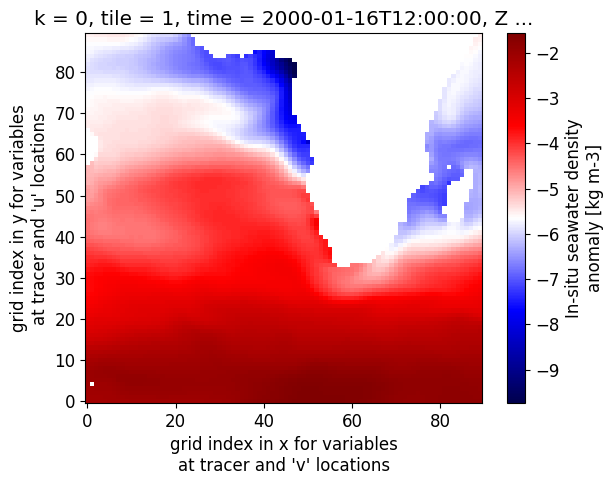

In [4]:
densanom = ds_denspress_mo.RHOAnoma
densanom_surf = densanom.isel(k=0)

plt.rcParams["font.size"] = 12    # set default font size for plots in this tutorial
densanom_surf_plot = (densanom_surf.isel(tile=1)).plot(cmap='seismic')

So that's one quick and easy way to get a look at a map of ECCO fields (at least on a single tile). The ```xarray``` package is very convenient to use with netCDF files as it retains data and coordinate labels/attributes even as you plot and manipulate the data.

But wait a moment...why are all of the density values negative?? The variable that we just plotted is the "in-situ seawater density anomaly". But anomaly relative to what? Let's consult the attributes for this variable, contained in the variable's DataArray.

> Tip: When a variable is subsetted from an xarray DataSet, an xarray DataArrray object is created. An xarray DataArray contains only one data variable, but retains coordinates and attributes from the parent Dataset.

In [5]:
densanom

<xarray.DataArray 'RHOAnoma' (time: 1, k: 50, tile: 13, j: 90, i: 90)> Size: 21MB
[5265000 values with dtype=float32]
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 8B 2000-01-16T12:00:00
    XC       (tile, j, i) float32 421kB ...
    YC       (tile, j, i) float32 421kB ...
    Z        (k) float32 200B ...
Attributes:
    long_name:              In-situ seawater density anomaly
    units:                  kg m-3
    coverage_content_type:  modelResult
    valid_min:              -18.81316375732422
    valid_max:              25.540061950683594
    comment:                In-situ seawater density anomaly relative to the ...

Note the attribute "comment" at the bottom. The density anomaly is relative to a constant value, 1029 kg m-3. So if we need the actual density value, we add 1029 to the density anomaly.

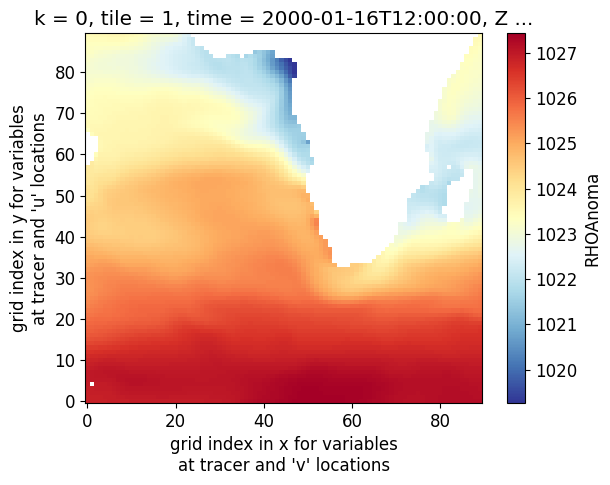

In [6]:
rhoConst = 1029.
dens = rhoConst + densanom
dens_surf = dens.isel(k=0)
dens_surf_plot = (dens_surf.isel(tile=1)).plot(cmap='RdYlBu_r')   # trying out another colormap

The map looks the same, but the colorbar labels are now actual density values. However the colorbar label, which previously was assigned automatically by xarray's plot function, got confused since we created a new data array (density) from the old array (density anomaly). We can update variable name and attributes in the **dens** DataArray accordingly.

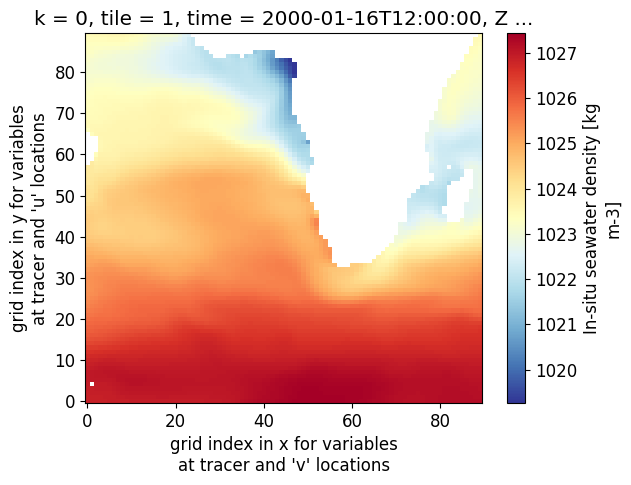

In [7]:
dens.name = 'RHO'
dens.attrs.update({'long_name': 'In-situ seawater density', 'units': 'kg m-3'})

# re-plot surface density
dens_surf = dens.isel(k=0)
dens_surf_plot = (dens_surf.isel(tile=1)).plot(cmap='RdYlBu_r')

Now let's plot pressure anomaly, and for a different depth level, ```k=20``` (the 21st depth level counting from the surface).

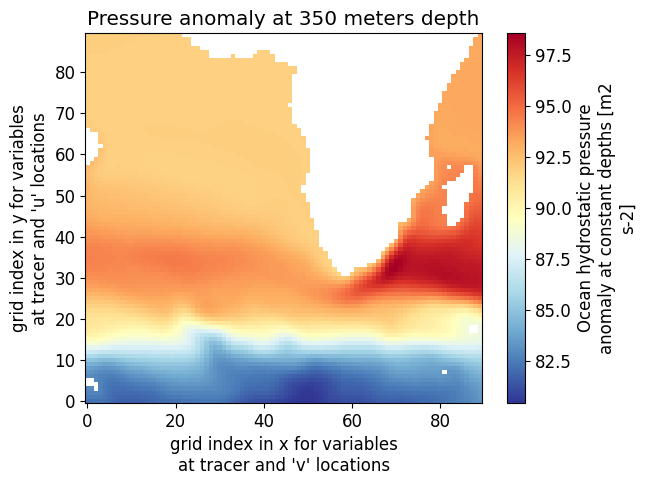

In [8]:
pressanom = ds_denspress_mo.PHIHYDcR
k_plot = 20
pressanom_plot = (pressanom.isel(tile=1,k=k_plot)).plot(cmap='RdYlBu_r')
# change plot title to show depth of plotted level
depth_plot_level = -pressanom.Z[k_plot].values      # sign change, so depth is given as positive number
plt.title('Pressure anomaly at ' + str(int(depth_plot_level)) + ' meters depth')

plt.show()

As you can see, the units are different from standard pressure units (which would be N m-2 or kg m-1 s-2). Consult the attributes for this variable:

In [9]:
pressanom

<xarray.DataArray 'PHIHYDcR' (time: 1, k: 50, tile: 13, j: 90, i: 90)> Size: 21MB
[5265000 values with dtype=float32]
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 8B 2000-01-16T12:00:00
    XC       (tile, j, i) float32 421kB ...
    YC       (tile, j, i) float32 421kB ...
    Z        (k) float32 200B ...
Attributes:
    long_name:              Ocean hydrostatic pressure anomaly at constant de...
    units:                  m2 s-2
    coverage_content_type:  modelResult
    comment:                PHIHYD = p(k) / rhoConst - g z(k,t), where p = hy...
    valid_min:              78.17041778564453
    valid_max:              783.6217041015625

That's a long comment! But what we need to know is that **PHIHYDcR** is related to the actual in-situ ocean pressure $p$ by

$$
{\rm{PHIHYDcR}} = \frac{p}{\rm{rhoConst}} - gz
$$

where $z$ is a depth coordinate, and rhoConst and $g$ are constants. Therefore, the $gz$ term does not impact the computation of ***horizontal*** gradients of pressure, which is what we need for geostrophic balance.

## Compute and map geostrophic balance

Now that we are aware of the corrections needed to get actual in-situ density and pressure (gradients) from ECCO, we are ready to assess geostrophic balance. Let's consider the ```k=20``` depth level again; we are deliberately avoiding plotting at the surface for reasons that will be apparent later! 

The right-hand side of the geostrophic balance equations are $(1/\rho){p_x}$ and $-(1/\rho){p_y}$, and $p_x$ and $p_y$ can be computed as

$$
p_x = ({\rm{rhoConst}})\frac{\partial}{\partial{x}}{\rm{PHIHYDcR}}
$$
$$
p_y = ({\rm{rhoConst}})\frac{\partial}{\partial{y}}{\rm{PHIHYDcR}}
$$

with ${\rm rhoConst} = 1029 \, {\rm kg \, m}^{-3}$.

In [10]:
# grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
# grid_params_file = "GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc"
# if incloud_access == True:
#     grid_params_file_path = files_grid_dict[grid_params_shortname]
# else:
#     grid_params_file_path = join(download_root_dir,grid_params_shortname,grid_params_file)

# # load grid parameters file
# ds_grid = xr.open_dataset(grid_params_file_path)
# ds_grid

### Operations on the native model grid

If you expand the "Data variables" section in the above Dataset summary, you'll see a number of grid parameters, and you can look at their descriptions by clicking on the "sheet of paper" icon to the right of each one. To compute $x$- and $y$-derivatives of pressure, we recall that the pressure variable (PHIHYD) is located on coordinates (time,k,tile,j,i). The (j,i) coordinates indicate that pressure is "centered" in a given grid cell. The distance *between* the centers of grid cells is given by the variables **dxC** and **dyC** (the "C" indicates distance between grid cell centers).

Now we can compute the derivatives of pressure and the right-hand side of the geostrophic balance equations. Because the native grid of ECCOv4 is composed of 13 tiles, when we difference or interpolate values across the tile edges, things can get complicated! Fortunately the ```xgcm``` package that was imported previously can help us with those operations. First we specify the connections between tiles in a Python dictionary, then create an xgcm Grid object that will allow us to carry out differencing and interpolation across the tile edges. We will need to both difference and interpolate to end up with pressure gradient values that are located at the center (i,j) of the grid cells.

In [11]:
# # create xgcm Grid object
xgcm_grid = ecco.get_llc_grid(ds_grid)

# compute derivatives of pressure in x and y
d_press_dx = (xgcm_grid.diff(rhoConst*pressanom,axis="X",boundary='extend'))/ds_grid.dxC
d_press_dy = (xgcm_grid.diff(rhoConst*pressanom,axis="Y",boundary='extend'))/ds_grid.dyC
# convert DataArray content from dask to numpy arrays 
# (dask arrays might have issues with interp_2d_vector fcn)
d_press_dx.data = d_press_dx.values
d_press_dy.data = d_press_dy.values

# interpolate (vector) gradient values to center of grid cells
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    # use this to ignore future warnings caused by interp_2d_vector function
    press_grads_interp = xgcm_grid.interp_2d_vector({"X":d_press_dx,"Y":d_press_dy},boundary='extend')
dp_dx = press_grads_interp['X']
dp_dy = press_grads_interp['Y']
dp_dx.name = 'dp_dx'
dp_dy.name = 'dp_dy'

dp_dx

/usr/local/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


<xarray.DataArray 'dp_dx' (time: 1, k: 50, tile: 13, j: 90, i: 90)> Size: 21MB
array([[[[[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [-1.78578217e-03, -2.80201435e-04,  4.48737061e-04, ...,
            2.56811129e-03,  2.54054624e-03,  2.38151103e-03],
          [-1.97579130e-03, -1.17824820e-04,  6.02442888e-04, ...,
            2.95511540e-03,  3.09964363e-03,  3.09713813e-03],
          [-1.60034164e-03,  3.31102929e-04,  6.47389097e-04, ...,
            3.22869234e-03,  3.55401146e-03,  3.75702744e-03]],

         [[-8.98729253e-04,  7.29348627e-04,  2.39784946e-04, ...,
            3.42662539e-03,  3.89235793e-03,  4.29460499e-03],
          [-2.40144931e-04,  7.03949365e-04, -7.84797710e-04, ...,
            3.54899094e-03,  4.10596048e-03,  4.68219491e-03],
          [ 5.17581939e-05,  1.75516907e-04, -2.09984998e-03, ...,
            3.58781964e-03,  4.15722188e-03,  4.85306140e-03],
...
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]]]]],
      dtype=float32)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: time

Notice that the DataArray **dp_dx** has (j,i) horizontal coordinates, indicating that it is centered in the grid cells (after the interpolation operation). You can check that the same is true of **dp_dy**.

### Right-hand side

Now we use density to compute and plot the right-hand side of the geostrophic balance equations. Note that these plots adjust the colormap in order to mask land areas in black.

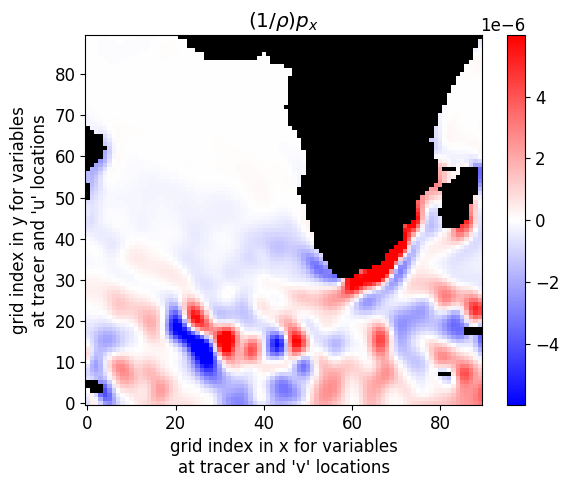

In [12]:
# compute right-hand side of geostrophic balance equations
geos_bal_RHS_1 = dp_dx/dens
geos_bal_RHS_2 = -dp_dy/dens

geos_bal_RHS_1 = geos_bal_RHS_1.where(ds_grid.maskC,np.nan)    # mask land areas with NaNs
geos_bal_RHS_2 = geos_bal_RHS_2.where(ds_grid.maskC)           # note that 'where' also masks with NaNs by default

# plot RHS of 1st geostrophic balance equation
curr_plot = (geos_bal_RHS_1.isel(tile=1,k=20)).plot(cmap='bwr')
# render NaNs (land areas) as black
cmap_nanmasked = curr_plot.cmap.copy()
cmap_nanmasked.set_bad('black')
curr_plot.cmap = cmap_nanmasked
# Note: Matplotlib plot text (such as the title below) can include LaTeX,
# but special characters such as backslash \ must include an extra "escape" backslash \
# in order to render correctly
plt.title('$(1/\\rho)p_x$')
# adjust colormap limits (multiply by 0.3)
curr_clim = np.asarray(curr_plot.get_clim())
curr_plot.set_clim(0.3*curr_clim)

plt.show()

### Left-hand side

To compute the left-hand side of the geostrophic balance equations we need to center the velocity fields in the grid cells and compute $f$. With the tools we've covered so far, this is fairly straightforward.

The code below also includes a function to scale the colormaps/colorbars based on the range of values present in the maps. As you write more code in Python, you will likely find yourself relying more and more on functions, rather than scripts or code blocks that run linearly top to bottom.

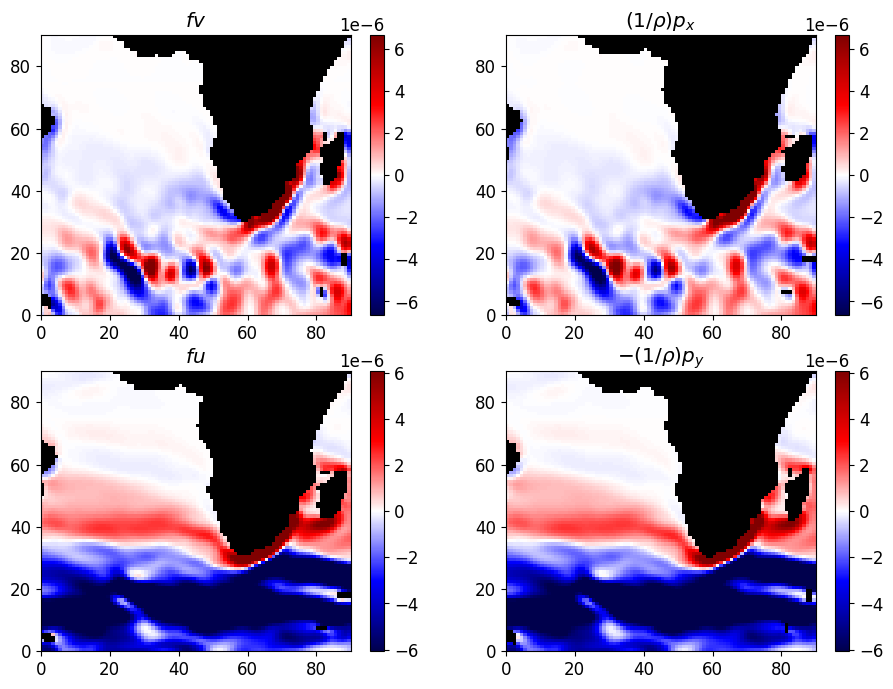

In [13]:
"""
Note: the model velocities UVEL/u and VVEL/v are defined on the model grid axes.
On some tiles (like tile=1 which we plot below) 
u and v will be essentially the eastward and northward velocity respectively.
But on other tiles the model axes are very different from geographic axes.
What matters for now is that these two components are always locally perpendicular.
"""
# interpolate velocities to center of grid cells
ds_vel_mo.UVEL.data = ds_vel_mo.UVEL.values
ds_vel_mo.VVEL.data = ds_vel_mo.VVEL.values
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vel_interp = xgcm_grid.interp_2d_vector({'X':ds_vel_mo.UVEL,'Y':ds_vel_mo.VVEL},boundary='extend')
u = vel_interp['X']
v = vel_interp['Y']

# compute f from latitude of grid cell centers
lat = ds_grid.YC
Omega = (2*np.pi)/86164
lat_rad = (np.pi/180)*lat    # convert latitude from degrees to radians
f = 2*Omega*np.sin(lat_rad)

# compute left-hand side of geostrophic balance equations
geos_bal_LHS_1 = f*v
geos_bal_LHS_2 = f*u

geos_bal_LHS_1 = geos_bal_LHS_1.where(ds_grid.maskC)    # mask land areas with NaNs
geos_bal_LHS_2 = geos_bal_LHS_2.where(ds_grid.maskC)


# Introduce function to scale colormap
def cmap_zerocent_scale(plot,scale_factor):
    """
    Center colormap at zero and scale relative to existing |maximum| value, 
    given plot object and scale_factor, a number of type float.
    Returns new colormap limits as new_clim.
    """
    curr_clim = plot.get_clim()
    new_clim = (scale_factor*np.max(np.abs(curr_clim)))*np.array([-1,1])
    plot.set_clim(new_clim)
    return new_clim


# tile and k indices to plot
tile_plot = 1
k_plot = 20
# dictionary to select tile and k indices (can then pass this to isel to save space)
isel_dict = {'tile':tile_plot,'k':k_plot}


# create figure
fig,axs = plt.subplots(2,2,figsize=(11,8))

# set NaN masking in colormap in advance 
# (in contrast to previous method setting NaN mask after plot is created)
seismic_nanmasked = plt.get_cmap('seismic').copy()
seismic_nanmasked.set_bad('black')


curr_ax = axs[0,0]
curr_plot = curr_ax.pcolormesh((geos_bal_LHS_1.isel(tile=tile_plot,k=k_plot)).squeeze(),cmap=seismic_nanmasked)
plot_clim = cmap_zerocent_scale(curr_plot,0.3)   # centers colormap at zero and scales extent by 0.3
curr_ax.set_title('$fv$')
fig.colorbar(curr_plot,ax=curr_ax)
curr_ax = axs[0,1]
curr_plot = curr_ax.pcolormesh((geos_bal_RHS_1.isel(tile=tile_plot,k=k_plot)).squeeze(),cmap=seismic_nanmasked)
curr_plot.set_clim(plot_clim)    # set RHS colormap limits to same values as LHS
curr_ax.set_title('$(1/\\rho)p_x$')
fig.colorbar(curr_plot,ax=curr_ax)

curr_ax = axs[1,0]
curr_plot = curr_ax.pcolormesh((geos_bal_LHS_2.isel(tile=tile_plot,k=k_plot)).squeeze(),cmap=seismic_nanmasked)
plot_clim = cmap_zerocent_scale(curr_plot,0.3)
curr_ax.set_title('$fu$')
fig.colorbar(curr_plot,ax=curr_ax)
curr_ax = axs[1,1]
curr_plot = curr_ax.pcolormesh((geos_bal_RHS_2.isel(tile=tile_plot,k=k_plot)).squeeze(),cmap=seismic_nanmasked)
curr_plot.set_clim(plot_clim)    # set RHS colormap limits to same values as LHS
curr_ax.set_title('$-(1/\\rho)p_y$')
fig.colorbar(curr_plot,ax=curr_ax)

plt.show()

As you can see, the left and right plots in each row are nearly identical!

We can also plot the equation divided by $f$ so each side is in units of velocity. Actual velocities $v$, $u$ are on the left, and *geostrophic* velocities $v_g$, $u_g$ are on the right--the velocities that are "explained" by geostrophic balance.

$$
v_g = \frac{1}{f{\rho}}p_x
$$
$$
u_g = -\frac{1}{f{\rho}}p_y
$$

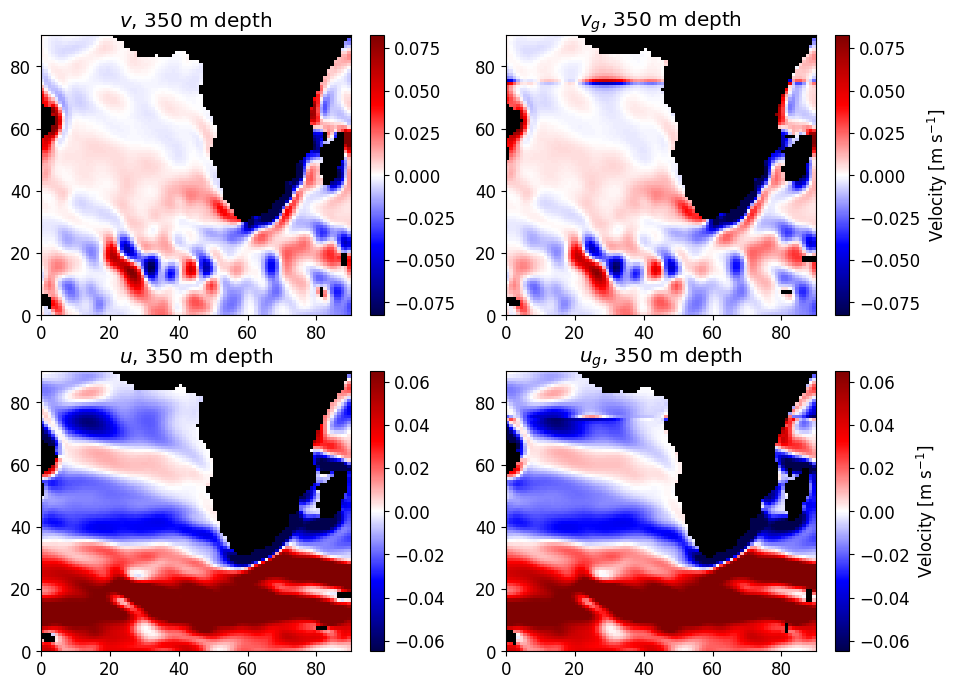

In [14]:
# compute geostrophic velocities
v_g = geos_bal_RHS_1/f
u_g = geos_bal_RHS_2/f

v_g = v_g.where(ds_grid.maskC)    # mask land areas with NaNs
u_g = u_g.where(ds_grid.maskC)


# tile and k indices to plot
tile_plot = 1
k_plot = 20
# dictionary to select tile and k indices (can then pass this to isel to save space)
isel_dict = {'tile':tile_plot,'k':k_plot}


# identify depth level for plot titles
depth_plot_level = -ds_grid.Z[k_plot].values
# convert depth level (rounded to nearest meter) to a string for plot titles
depth_str = str(int(depth_plot_level))


# plot LHS and RHS of equations for tile = 1, k = 20 in a figure with 2x2 subplots
# arrays need to have singleton (time) dimension removed with .squeeze() before plotting

# create figure
fig,axs = plt.subplots(2,2,figsize=(11,8))

curr_ax = axs[0,0]
curr_plot = curr_ax.pcolormesh((v.isel(isel_dict)).squeeze(),cmap=seismic_nanmasked)
plot_clim = cmap_zerocent_scale(curr_plot,0.3)
curr_ax.set_title('$v$, ' + depth_str + ' m depth')
cbar = fig.colorbar(curr_plot,ax=axs[0,0])
# cbar.set_label('Velocity [m s$^{-1}$]')
curr_ax = axs[0,1]
curr_plot = curr_ax.pcolormesh((v_g.isel(isel_dict)).squeeze(),cmap=seismic_nanmasked)
curr_plot.set_clim(plot_clim)
curr_ax.set_title('$v_g$, ' + depth_str + ' m depth')
cbar = fig.colorbar(curr_plot,ax=axs[0,1])
cbar.set_label('Velocity [m s$^{-1}$]')

curr_ax = axs[1,0]
curr_plot = curr_ax.pcolormesh((u.isel(isel_dict)).squeeze(),cmap=seismic_nanmasked)
plot_clim = cmap_zerocent_scale(curr_plot,0.3)
curr_ax.set_title('$u$, ' + depth_str + ' m depth')
cbar = fig.colorbar(curr_plot,ax=axs[1,0])
# cbar.set_label('Velocity [m s$^{-1}$]')
curr_ax = axs[1,1]
curr_plot = axs[1,1].pcolormesh((u_g.isel(isel_dict)).squeeze(),cmap=seismic_nanmasked)
curr_plot.set_clim(plot_clim)
curr_ax.set_title('$u_g$, ' + depth_str + ' m depth')
cbar = fig.colorbar(curr_plot,ax=axs[1,1])
cbar.set_label('Velocity [m s$^{-1}$]')

plt.show()

Notice some weirdness in the geostrophic velocity maps (right column) near the equator. Hmm, why would that be...?

We can also visualize (actual) velocities as vectors relative to pressure anomaly contours. This looks much like maps of the atmospheric circulation that you might see in a weather report.

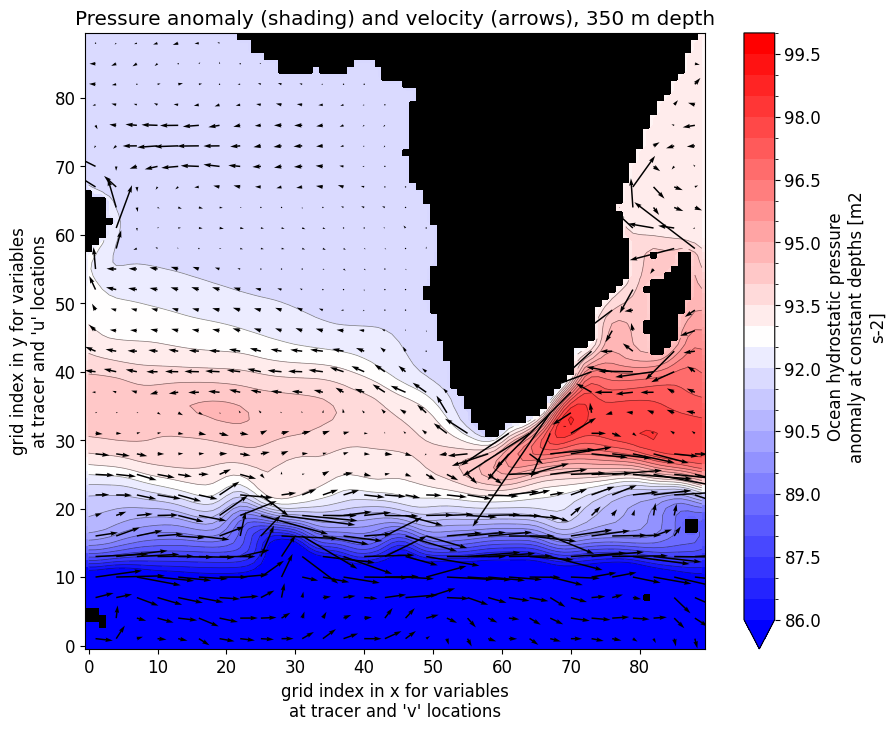

In [15]:
pressanom_plot = pressanom.where(ds_grid.maskC)    # mask land areas with NaNs

# tile and k indices to plot
tile_plot = 1
k_plot = 20
# dictionary to select tile and k indices (can then pass this to isel to save space)
isel_dict = {'tile':tile_plot,'k':k_plot}

# identify depth level for plot titles
depth_plot_level = -ds_grid.Z[k_plot].values
# convert depth level (rounded to nearest meter) to a string for plot titles
depth_str = str(int(depth_plot_level))


fig,ax = plt.subplots(figsize=(10,8))

# create 'bwr' colormap with NaN masking
bwr_nanmasked = plt.get_cmap('bwr').copy()
bwr_nanmasked.set_bad('black')

# plot filled contours, contour lines, and land mask
# (plots with higher zorder values are visible over lower zorder values)
curr_plot = (pressanom_plot.isel(isel_dict).squeeze()).plot.contourf(cmap=bwr_nanmasked,levels=29,vmin=86,vmax=100,zorder=50)
curr_contours = (pressanom_plot.isel(isel_dict).squeeze()).plot.contour(colors='black',levels=29,vmin=86,vmax=100,alpha=0.5,\
                                                                             linewidths=0.5,zorder=100)
curr_plot_mask = (pressanom_plot.isel(isel_dict).squeeze()).plot(cmap=bwr_nanmasked,add_colorbar=False,vmin=86,vmax=100,zorder=0)

# plot velocity vectors using quiver
u_plot = (u.isel(isel_dict)).squeeze()
v_plot = (v.isel(isel_dict)).squeeze()
arrow_spacing = 3     # plot arrows spaced out (otherwise there is an arrow for every grid point)
ind_arrow_plot = np.r_[1:u_plot.shape[-1]:arrow_spacing]
curr_velplot = ax.quiver(ind_arrow_plot,ind_arrow_plot,u_plot[ind_arrow_plot,ind_arrow_plot],\
                        v_plot[ind_arrow_plot,ind_arrow_plot],scale=1.5,zorder=150)
ax.set_title('Pressure anomaly (shading) and velocity (arrows), ' + depth_str + ' m depth')

plt.show()

## Assessment of geostrophic balance

### Normalized difference maps

How can we can assess the variation in geostrophic balance and how well it accounts for ocean velocity globally? One way is to plot the normalized difference between actual and geostrophic velocities. We could do this for $v$ and $u$ components separately, but to get the most information in one plot, we can do this with the magnitude of difference between the velocity vectors.

$$
\vert{\Delta{\bf u}}\vert_{\rm norm} = \frac{\vert{{\bf u} - {\bf u_g}}\vert}{\vert{\bf u}\vert}
$$


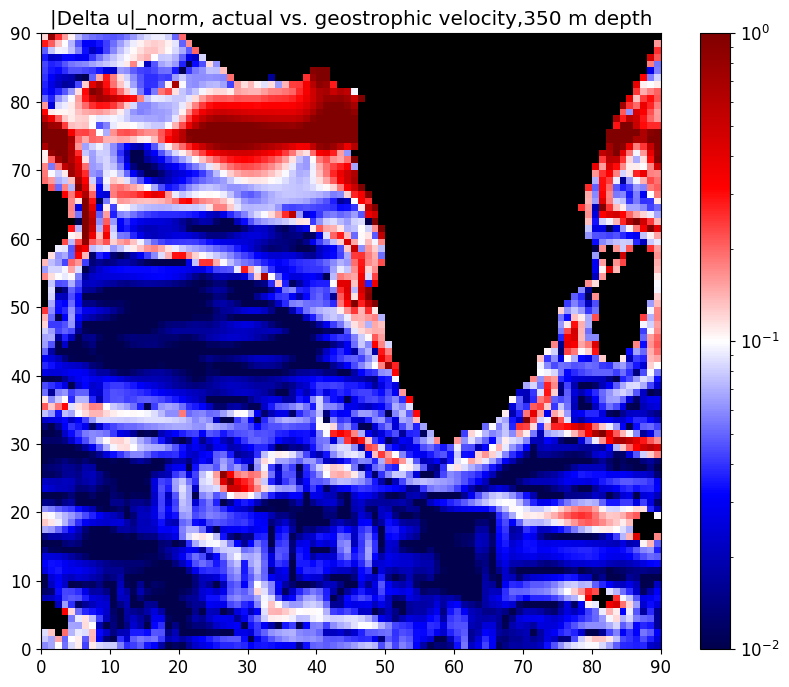

In [16]:
# difference between actual and geostrophic velocity vectors (in complex plane)

u_diff = u - u_g
v_diff = v - v_g
vel_diff_complex = u_diff + (1j*v_diff)    # in Python, imaginary number i is indicated by 1j
vel_complex = u + (1j*v)

# normalize magnitude of difference vector by magnitude of actual velocity
vel_diff_abs = np.abs(vel_diff_complex)
vel_abs = np.abs(vel_complex)
vel_diff_norm = vel_diff_abs/vel_abs


# tile and k indices to plot
tile_plot = 1
k_plot = 20
# dictionary to select tile and k indices (can then pass this to isel to save space)
isel_dict = {'tile':tile_plot,'k':k_plot}

# identify depth level for plot titles
depth_plot_level = -ds_grid.Z[k_plot].values
# convert depth level (rounded to nearest meter) to a string for plot titles
depth_str = str(int(depth_plot_level))


# plot normalized difference
fig,ax = plt.subplots(figsize=(10,8))
array_plot = (vel_diff_norm.isel(isel_dict)).squeeze()
# let's use a logarithmic color scale for this plot!
import matplotlib.colors as colors
# set axis limits to 0.01 and 1 (values outside this range will be saturated)
curr_plot = ax.pcolormesh(array_plot,norm=colors.LogNorm(vmin=0.01,vmax=1),cmap=seismic_nanmasked)
fig.colorbar(curr_plot,ax=ax)
ax.set_title('|Delta u|_norm, actual vs. geostrophic velocity,' + depth_str + ' m depth')

plt.show()

A normalized difference of 0.1 (white on the above map) can be considered an approximate threshold for where the geostrophic velocity is a decent predictor of actual velocity. Therefore, what the above map shows is areas where geostrophic velocity is a good predictor of actual velocity (blue), and areas where the geostrophic velocity is a poor predictor (red). Note that where the actual velocity magnitude is very small, the map may show red even though the velocity difference itself isn't large. To focus on areas with more substantial velocities, we can remap with the small-velocity points masked out.

To help us out with this, we'll introduce a new function that plots a mask. Note that we can also use this function (instead of masking with `set_bad`) to mask land areas, and we'll do this below.

In [17]:
# Introduce function to plot mask as pcolormesh
def plot_mask(*args,ax=None,color):
    """
    Plot mask, given input parameters:
    - X, Y: (optional) coordinates as 1-D or 2-D NumPy arrays or xarray DataArrays
    - mask: 2-D array of boolean values (True/False or 1/0), NumPy or xarray
    - axes: axes to plot on, defaults to current axes
    - color: a string indicating a color in Matplotlib, or a 3-element tuple or NumPy array indicating RGB color values
    
    Returns plot_obj, the plot object of the mask 
    """
    if len(args) == 1:
        mask = args[0]
    else:
        X = args[0]
        Y = args[1]
        mask = args[2]
    # set alpha values to 1 where mask is plotted, 0 otherwise
    if str(type(mask))[0:5] == 'xarray':
        mask = mask.values
    # get color for mask
    if isinstance(color,str):
        import matplotlib.colors as mcolors
        color_rgb = mcolors.to_rgb(color)
    elif (isinstance(color,tuple)) and (len(color) == 3):
        color_rgb = np.asarray(color)
    elif (isinstance(color,np.ndarray)) and (len(color) == 3):
        color_rgb = color
    else:
        raise TypeError("input parameter 'color' has incorrect type or number of elements")
    # create a colormap using a 2x4 array with two RGBA entries
    # the RGB entries are the same in each row
    # in the 1st row alpha=0, in the 2nd row alpha=1
    cmap_array = np.hstack((np.tile(color_rgb,(2,1)),np.array([[0],[1]])))
    from matplotlib.colors import ListedColormap
    colormap = ListedColormap(cmap_array)
    # get axis limits of existing plot
    if ax is None:
        ax = plt.gca()
    existing_xlim = ax.get_xlim()
    existing_ylim = ax.get_ylim()
    # plot mask using colormap just created, with alpha=1 where mask=1 or True
    if len(args) == 1:
        plot_obj = ax.pcolormesh(mask,cmap=colormap,vmin=0.,vmax=1.,zorder=50)
    else:
        plot_obj = ax.pcolormesh(X,Y,mask,cmap=colormap,vmin=0.,vmax=1.,zorder=50)
    # set axis limits of mask to axis limits of existing plot
    ax.set_xlim(existing_xlim)
    ax.set_ylim(existing_ylim)
    
    return plot_obj

Now we'll create two plots side-by-side, one without and one with the small-velocity mask.

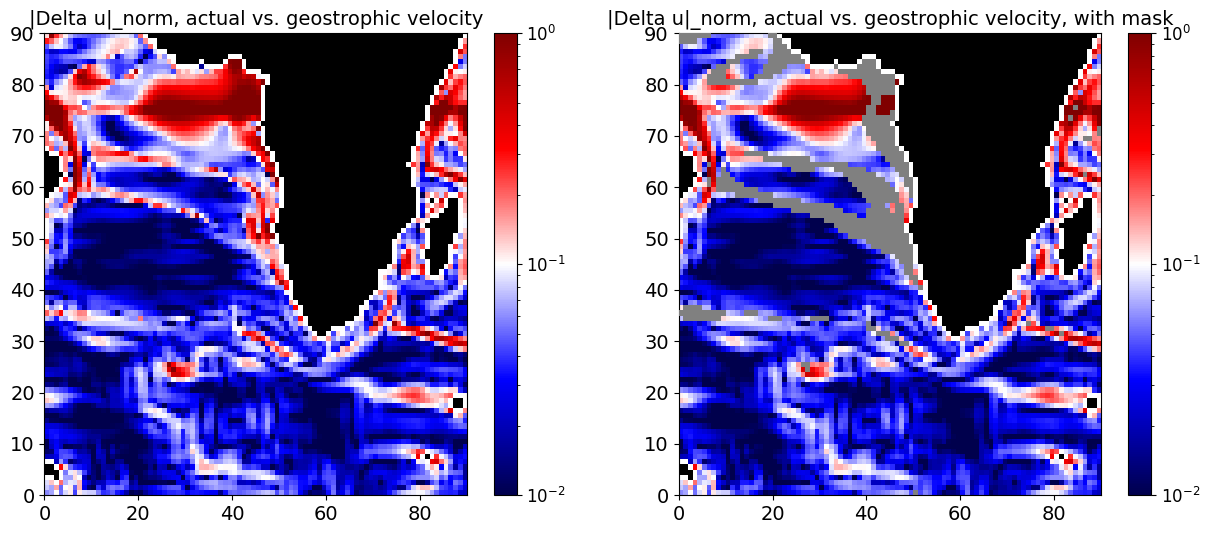

In [18]:
# load land mask (a boolean array) from grid parameters
# Note: maskC has True (1) over water and False (0) over land
# we want the reverse for a land_mask, so ~ switches the boolean values
land_mask = ~ds_grid.maskC

# small velocity mask
mask_threshold = 0.005    # mask out velocities <0.5 cm s-1
# Note: the .values attribute contains the content of the data variable as a NumPy array.
# This allows additional operations not permitted in xarray,
# such as boolean indexing used here to mask with NaNs.
mask_smallvel = (vel_abs < mask_threshold)


# dictionary to select tile and k indices (can then pass this to isel to save space)
isel_dict = {'tile':tile_plot,'k':k_plot}

# plot normalized difference without and with mask
fig,axs = plt.subplots(1,2,figsize=(15,6))
curr_ax = axs[0]
curr_ax.tick_params(labelsize=14)
array_plot = vel_diff_norm.isel(isel_dict).squeeze()
curr_plot = curr_ax.pcolormesh(array_plot,norm=colors.LogNorm(vmin=0.01,vmax=1),cmap='seismic')
# plot land mask in black
plot_mask(land_mask.isel(isel_dict).squeeze(),ax=curr_ax,color='black')
curr_ax.set_title('|Delta u|_norm, actual vs. geostrophic velocity',fontsize=14)
fig.colorbar(curr_plot,ax=curr_ax)
curr_ax = axs[1]
curr_ax.tick_params(labelsize=14)
array_plot = vel_diff_norm.isel(isel_dict).squeeze()
curr_plot = curr_ax.pcolormesh(array_plot,norm=colors.LogNorm(vmin=0.01,vmax=1),cmap='seismic')
plot_mask(land_mask.isel(isel_dict).squeeze(),ax=curr_ax,color='black')
# plot small velocity mask in gray color, RGB=(0.5,0.5,0.5)
plot_mask(mask_smallvel.isel(isel_dict).squeeze(),ax=curr_ax,color=(0.5,0.5,0.5))
curr_ax.set_title('|Delta u|_norm, actual vs. geostrophic velocity, with mask',fontsize=14)
fig.colorbar(curr_plot,ax=curr_ax)

plt.show()

#### Global maps

Having mastered mapping on a single tile of the model grid, we can now plot maps that show the model's entire horizontal global domain. We'll use functions that are part of the ```ecco_v4_py``` package to do this in two ways here: (1) plotting 13 tiles side-by-side, and (2) plotting the model fields regridded to a global lat-lon projection.

First the 13 tiles map. The Plotting Tiles tutorial shows a number of configurations that tiles can be plotted; here we use the **latlon** layout with the Arctic tile adjacent to tile=10.

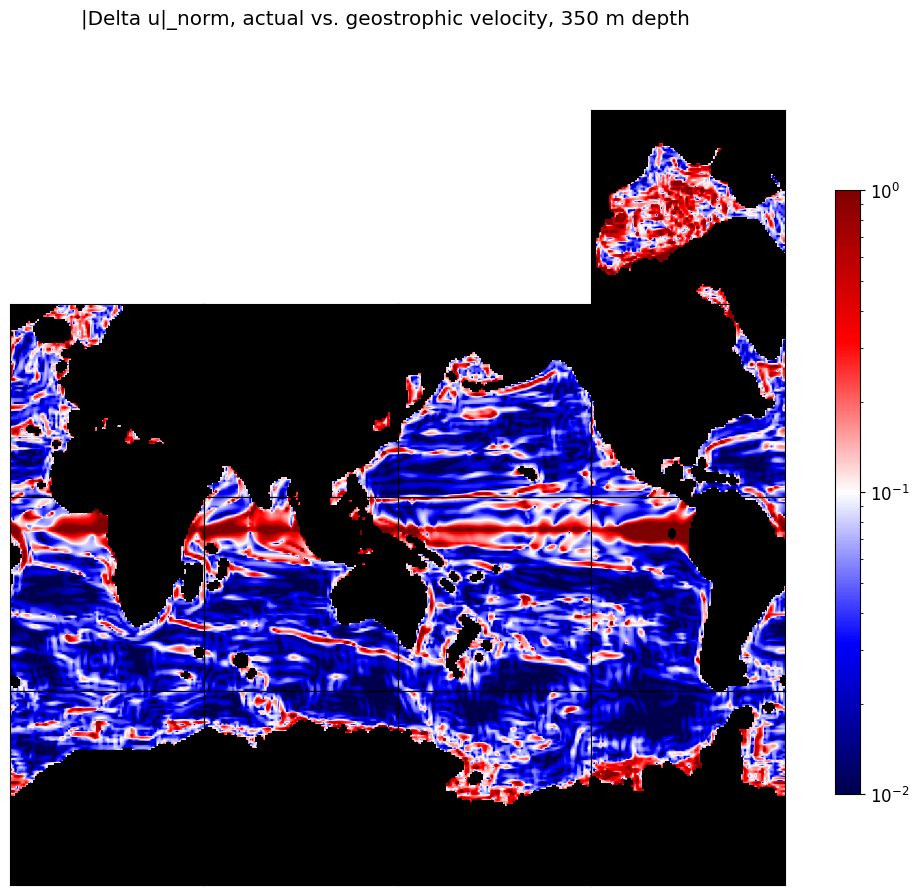

In [19]:
# k index (depth level) to plot
k_plot = 20

# identify depth level for plot titles
depth_plot_level = -ds_grid.Z[k_plot].values
# convert depth level (rounded to nearest meter) to a string for plot titles
depth_str = str(int(depth_plot_level))


# 13 tiles map using ecco_v4_py function plot_tiles
# (we'll leave out the small-velocity mask for the global maps)
curr_obj = ecco.plot_tiles(vel_diff_norm.isel(k=k_plot).squeeze(),\
                            cmap=seismic_nanmasked,show_colorbar=False,fig_size=10,\
                            layout='latlon',rotate_to_latlon=True,\
                            show_tile_labels=False,\
                            Arctic_cap_tile_location=10)
curr_fig = curr_obj[0]
# loop through tiles to adjust color scaling and add mask
tile_order = np.array([-1,-1,-1,6, \
                         2,5,7,10,  \
                         1,4,8,11, \
                         0,3,9,12])
for idx,curr_ax in enumerate(curr_fig.get_axes()):
    # set color scaling to lognormal range we used previously
    if len(curr_ax.get_images()) > 0:
        (curr_ax.get_images()[0]).norm = colors.LogNorm(vmin=0.01,vmax=1)

# add colorbar
cbar_ax = curr_fig.add_axes([0.95,0.2,0.025,0.6])
cbar = curr_fig.colorbar(plt.cm.ScalarMappable(\
                            norm=colors.LogNorm(vmin=0.01,vmax=1),\
                            cmap='seismic'),cax=cbar_ax)
# add title
curr_fig.suptitle('|Delta u|_norm, actual vs. geostrophic velocity, ' + depth_str + ' m depth')

plt.show()

And on a global map projection (here the Robinson projection is used):

/usr/local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


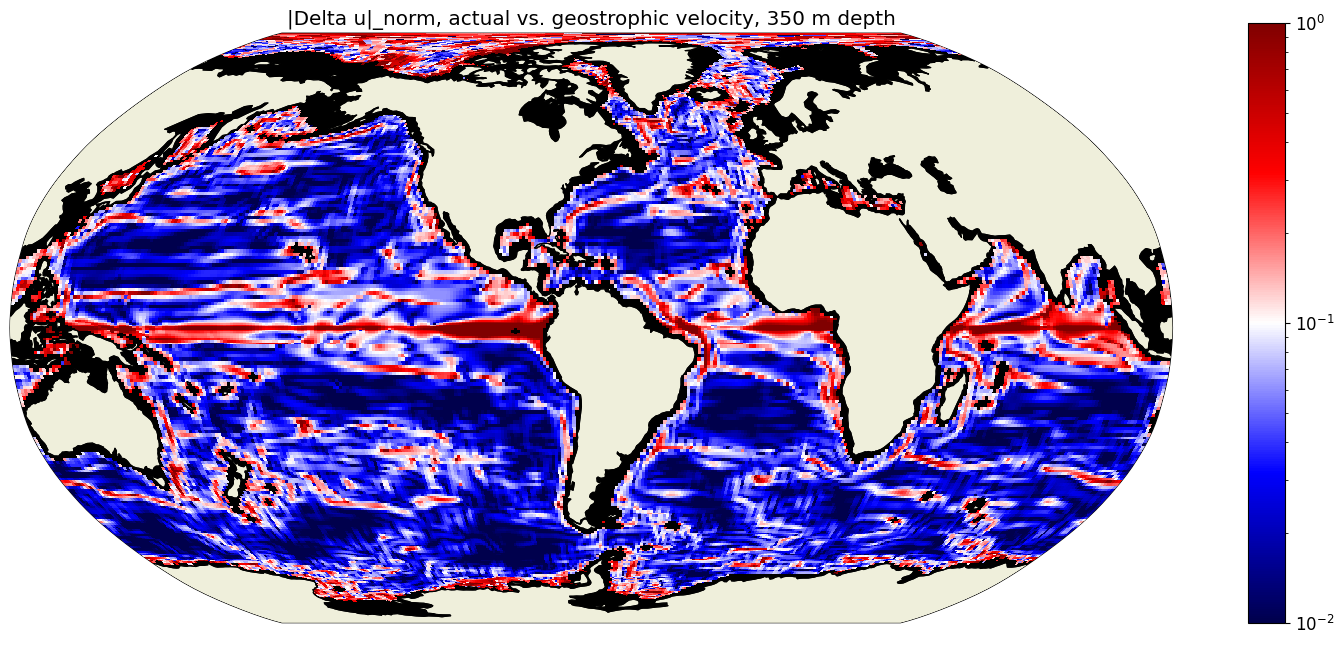

In [20]:
# k index (depth level) to plot
k_plot = 20

# global map projection using ecco_v4_py function plot_proj_to_latlon_grid
# Query help(ecco.plot_proj_to_latlon_grid) for a full list of input arguments.
curr_obj = ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,\
                                        vel_diff_norm.isel(k=k_plot).squeeze(),\
                                        cmap=seismic_nanmasked,show_colorbar=False,\
                                        show_land=True,projection_type='robin',\
                                        user_lon_0=-67,plot_type='pcolormesh')
curr_fig = curr_obj[0]
curr_ax = curr_obj[1]
curr_fig.set_figwidth(15)
curr_fig.set_figheight(10)
import matplotlib as mpl
# set color scaling to lognormal range
for handle in curr_ax.get_children():
    if isinstance(handle,mpl.collections.QuadMesh):
        handle.norm = colors.LogNorm(vmin=0.01,vmax=1)
# add colorbar with correct scaling
cbar_ax = curr_fig.add_axes([0.95,0.2,0.025,0.6])
cbar = curr_fig.colorbar(plt.cm.ScalarMappable(\
                            norm=colors.LogNorm(vmin=0.01,vmax=1),\
                            cmap=seismic_nanmasked),cax=cbar_ax)
# add title
curr_ax.set_title('|Delta u|_norm, actual vs. geostrophic velocity, ' + depth_str + ' m depth')

plt.show()

### Latitude and depth dependence

We can also plot $\vert{{\Delta}{\bf u}}\vert_{\rm norm}$ along a transect to consider its variation with depth. Let's plot an example along ```i=40``` on ```tile=1``` (which follows the line of longitude ${\rm 2.5}^{\circ}{\rm E}$):

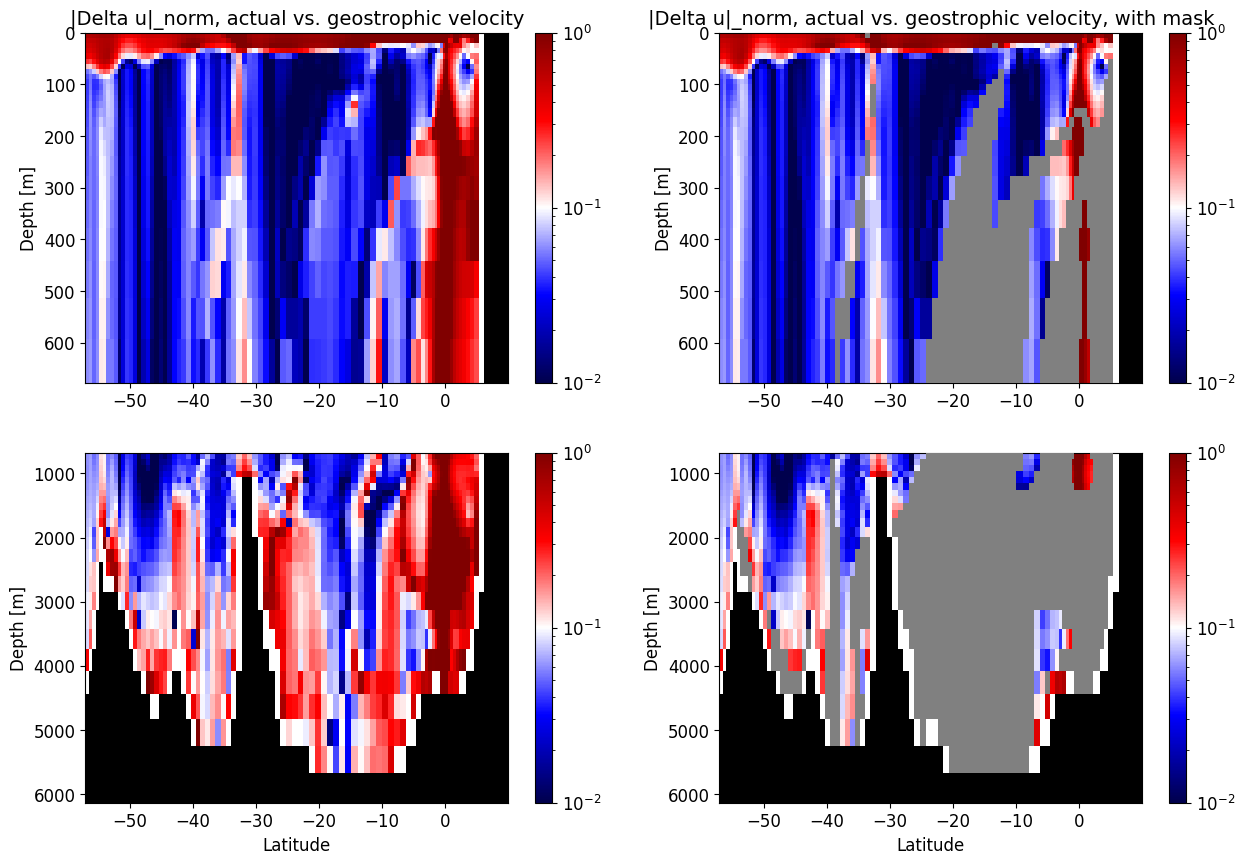

In [21]:
# tile and i indices to plot
tile_plot = 1
i_plot = 40
# dictionary to select tile and i (i_g) indices
isel_dict = {'tile':tile_plot,'i':i_plot}
isel_dict_ig = {'tile':tile_plot,'i_g':i_plot}

# compute land and small velocity masks
curr_land_mask = land_mask.isel(isel_dict).squeeze()
curr_mask_smallvel = mask_smallvel.isel(isel_dict).squeeze()


# plot normalized difference without and with mask
# here we'll plot top 25 and bottom 25 depth levels separately to accommodate different scales
fig,axs = plt.subplots(2,2,figsize=(15,10))
curr_ax = axs[0,0]

# Note: when specifying coordinates with a data array of size MxN
# Matplotlib will only use "flat" shading if coordinate dimensions are one larger than data array
# i.e., length M+1 and N+1, or (M+1)x(N+1), otherwise defaults to "nearest" shading
# bounding coordinates for upper pcolormesh plots
lat_plot = np.hstack(((ds_grid.YG.isel(isel_dict_ig)).squeeze(),\
                      ds_grid.YC_bnds.isel({**isel_dict,'j':-1,'nb':3})))
depth_plot = -ds_grid.Zp1[0:26].squeeze()    # top 25 depth levels

array_plot = (vel_diff_norm.isel(isel_dict)).squeeze()
curr_plot = curr_ax.pcolormesh(lat_plot,depth_plot,array_plot[0:25,:],\
                               norm=colors.LogNorm(vmin=0.01,vmax=1),cmap='seismic')
plot_mask(lat_plot,depth_plot,curr_land_mask[0:25,:],ax=curr_ax,color='black')
curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
curr_ax.set_ylabel('Depth [m]')
curr_ax.set_title('|Delta u|_norm, actual vs. geostrophic velocity',fontsize=14)
fig.colorbar(curr_plot,ax=curr_ax)
curr_ax = axs[0,1]
array_plot = (vel_diff_norm.isel(isel_dict)).squeeze()
curr_plot = curr_ax.pcolormesh(lat_plot,depth_plot,array_plot[0:25,:],\
                               norm=colors.LogNorm(vmin=0.01,vmax=1),cmap='seismic')
plot_mask(lat_plot,depth_plot,curr_land_mask[0:25,:],ax=curr_ax,color='black')
plot_mask(lat_plot,depth_plot,curr_mask_smallvel[0:25,:],ax=curr_ax,color=(0.5,0.5,0.5))
curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
curr_ax.set_ylabel('Depth [m]')
curr_ax.set_title('|Delta u|_norm, actual vs. geostrophic velocity, with mask',fontsize=14)
fig.colorbar(curr_plot,ax=curr_ax)

curr_ax = axs[1,0]

# bounding coordinates for lower pcolormesh plots
lat_plot = np.hstack(((ds_grid.YG.isel(isel_dict_ig)).squeeze(),\
                      ds_grid.YC_bnds.isel({**isel_dict,'j':-1,'nb':3})))
depth_plot = -ds_grid.Zp1[25:].squeeze()    # bottom 25 depth levels

array_plot = (vel_diff_norm.isel(isel_dict)).squeeze()
curr_plot = curr_ax.pcolormesh(lat_plot,depth_plot,array_plot[25:,:],\
                               norm=colors.LogNorm(vmin=0.01,vmax=1),cmap='seismic')
plot_mask(lat_plot,depth_plot,curr_land_mask[25:,:],ax=curr_ax,color='black')
curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
curr_ax.set_ylabel('Depth [m]')
curr_ax.set_xlabel('Latitude')
fig.colorbar(curr_plot,ax=curr_ax)
curr_ax = axs[1,1]
array_plot = (vel_diff_norm.isel(isel_dict)).squeeze()
curr_plot = curr_ax.pcolormesh(lat_plot,depth_plot,array_plot[25:,:],\
                               norm=colors.LogNorm(vmin=0.01,vmax=1),cmap='seismic')
plot_mask(lat_plot,depth_plot,curr_land_mask[25:,:],ax=curr_ax,color='black')
plot_mask(lat_plot,depth_plot,curr_mask_smallvel[25:,:],ax=curr_ax,color=(0.5,0.5,0.5))
curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
curr_ax.set_ylabel('Depth [m]')
curr_ax.set_xlabel('Latitude')
fig.colorbar(curr_plot,ax=curr_ax)

plt.show()

Can you see some patterns in the above plots? Most depths 100-1500 meters have a lot of blue, meaning geostrophic velocities are very good approximations of the actual velocities. But (1) close to the ocean surface, (2) close to the ocean bottom, and (3) near the equator there is a lot more red. So in those areas, some of the other terms in the momentum equations that we earlier considered to be negligible, may not actually be negligible. We'll explore some of these other balances in upcoming tutorials.

For now, let's explore these patterns in a more systematic way globally. The following code computes the normalized difference (weighted by the area of each grid cell) as a function of latitude and depth, for the global oceans. **Note: the ```mean_weighted_binned``` function may take a few minutes to run over the global domain.**

In [22]:
# bins of latitude
lat_bin_spacing = 2
lat_bin_bounds = np.c_[-90:90:lat_bin_spacing] + np.array([[0,lat_bin_spacing]])
lat_bin_centers = np.mean(lat_bin_bounds,axis=-1)

# bins of depth
depth_bin_bounds = -ds_grid.Z_bnds.values

vel_diff_abs = np.abs(vel_diff_complex)
vel_abs = np.abs(vel_complex)

# function to loop through and compute weighted mean in bins
def mean_weighted_binned(value_field,weighting,bin_field,bin_bounds):
    """
    Compute normalized difference in bins, given:
    - value_field: field of values to average
    - weighting: weighting of individual grid cells
    - bin_field: field to use in binning
    - bin_bounds: bound values of bins to use, as numpy array of size (N,2)
    """
    mean_weighted_inbins = np.empty((bin_bounds.shape[0]))
    mean_weighted_inbins.fill(np.nan)
    bin_field_broadcast_flat = (np.ones(value_field.shape)*bin_field).flatten()
    weighting_flat = weighting.flatten()
    value_field_flat = value_field.flatten()
    bin_idx_sorted = np.argsort(bin_field_broadcast_flat)   # flatten and sort bin field values
    sort_idx = (bin_field_broadcast_flat[bin_idx_sorted] >= bin_bounds[0,0]).nonzero()[0][0]
    curr_idx = bin_idx_sorted[sort_idx]
    curr_bin_val = bin_field_broadcast_flat[curr_idx]
    curr_bin_num = ((bin_bounds[:,0] <= curr_bin_val) & (bin_bounds[:,1] > curr_bin_val)).nonzero()[0][0]
    value_sum_inbin = 0.
    weighting_sum_inbin = 0.
    while curr_bin_val < bin_bounds[-1,1]:
        if np.logical_and(~np.isnan(value_field_flat[curr_idx]),~np.isinf(value_field_flat[curr_idx])):
            value_sum_inbin += weighting_flat[curr_idx]*value_field_flat[curr_idx]
            weighting_sum_inbin += weighting_flat[curr_idx]
        sort_idx += 1
        if sort_idx >= len(bin_idx_sorted):
            if weighting_sum_inbin > 0:
                mean_weighted_inbins[curr_bin_num] = value_sum_inbin/weighting_sum_inbin
            break
        curr_idx = bin_idx_sorted[sort_idx]
        curr_bin_val = bin_field_broadcast_flat[curr_idx]
        if curr_bin_val >= bin_bounds[curr_bin_num,1]:
            if weighting_sum_inbin > 0:
                mean_weighted_inbins[curr_bin_num] = value_sum_inbin/weighting_sum_inbin
            curr_bin_num = ((bin_bounds[:,0] <= curr_bin_val) & (bin_bounds[:,1] > curr_bin_val)).nonzero()[0][0]
            value_sum_inbin = 0.
            weighting_sum_inbin = 0.
    return mean_weighted_inbins


# compute norm diff, weighting by horizontal area of grid cells and masks

curr_weighting = ((~mask_smallvel)*(ds_grid.maskC)*(ds_grid.rA)).values

diff_norm_lat = mean_weighted_binned(vel_diff_norm.values,curr_weighting,\
                                    ds_grid.YC.values,lat_bin_bounds)
diff_norm_depth = mean_weighted_binned(vel_diff_norm.values,curr_weighting,\
                                    np.expand_dims(-ds_grid.Z.values,axis=(-3,-2,-1)),\
                                    depth_bin_bounds)

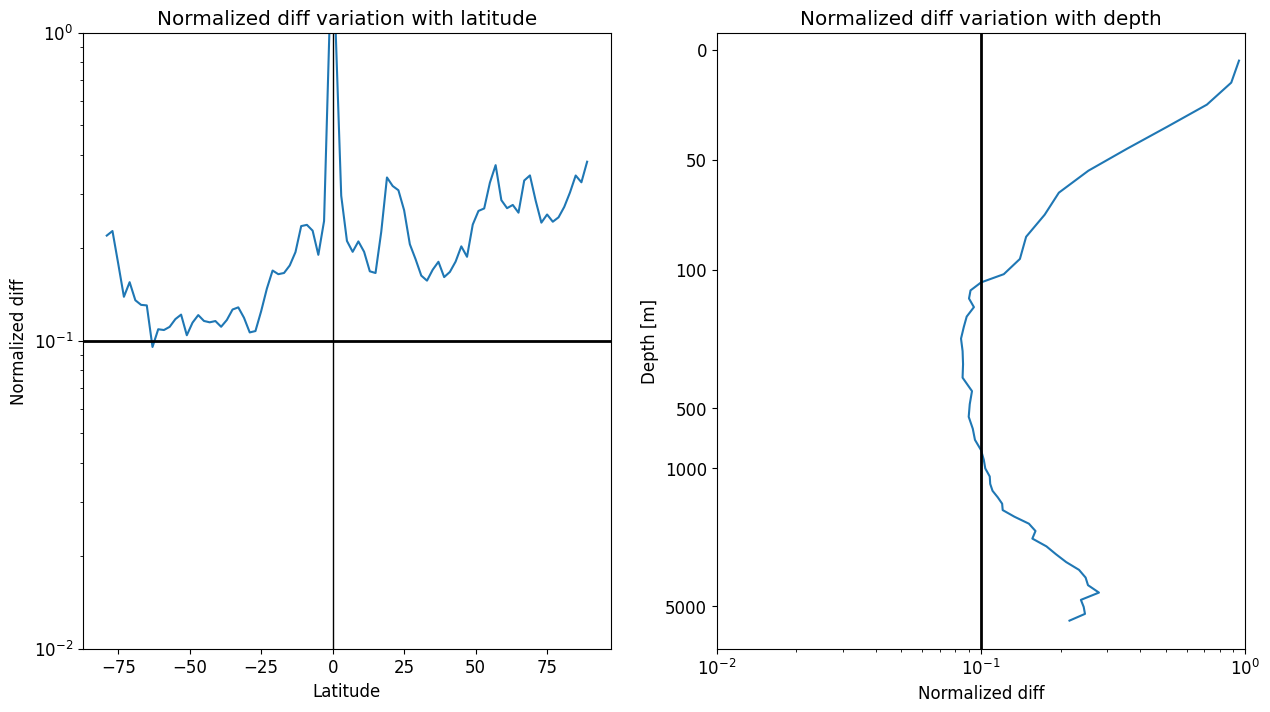

In [23]:
# plot normalized difference, binned by latitude and by depth
fig,axs = plt.subplots(1,2,figsize=(15,8))
curr_ax = axs[0]            
curr_ax.plot(lat_bin_centers,diff_norm_lat)
curr_ax.set_ylim(0.01,1)
curr_ax.set_yscale('log')
curr_ax.axhline(y=0.1,color='black',lw=2)
curr_ax.axvline(x=0,color='black',lw=1)
curr_ax.set_xlabel('Latitude')
curr_ax.set_ylabel('Normalized diff')
curr_ax.set_title('Normalized diff variation with latitude')
curr_ax = axs[1]
curr_ax.plot(diff_norm_depth,-ds_grid.Z)
# Note: in older versions of Matplotlib
# may need to use linthreshy instead of linthresh
curr_ax.set_yscale('symlog',linthresh=100)
curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
curr_ax.set_yticks([0,50,100,500,1000,5000])
curr_ax.set_yticklabels(['0','50','100','500','1000','5000'])
curr_ax.set_xlim(0.01,1)
curr_ax.set_xscale('log')
curr_ax.axvline(x=0.1,color='black',lw=2)
curr_ax.set_xlabel('Normalized diff')
curr_ax.set_ylabel('Depth [m]')
curr_ax.set_title('Normalized diff variation with depth')

plt.show()

Based on the normalized diff = 0.1 threshold discussed before, geostrophic balance doesn't hold particularly well at any latitude, and only at depths 100-1000 m. But let's try this again, masking for only 100-1000 m depths in the latitude plot, and only latitudes more than 5 degrees from the equator in the depth plot.

In [24]:
# latitude and depth masks

# create depth array that will broadcast correctly across horizontal dimensions
depth_expand_dims = np.expand_dims(-ds_grid.Z,axis=(-3,-2,-1))

depth_mask = np.logical_and(depth_expand_dims > 100,\
                            depth_expand_dims < 1000)
lat_mask = np.expand_dims((np.abs(ds_grid.YC) > 5),axis=0)


# compute norm diff with additional masks

curr_weighting = (depth_mask*(~mask_smallvel)*(ds_grid.maskC)*(ds_grid.rA)).values
diff_norm_lat_moremask = mean_weighted_binned(vel_diff_norm.values,curr_weighting,\
                                                ds_grid.YC.values,lat_bin_bounds)

curr_weighting = (lat_mask*(~mask_smallvel)*(ds_grid.maskC)*(ds_grid.rA)).values
diff_norm_depth_moremask = mean_weighted_binned(vel_diff_norm.values,curr_weighting,\
                                                depth_expand_dims,depth_bin_bounds)

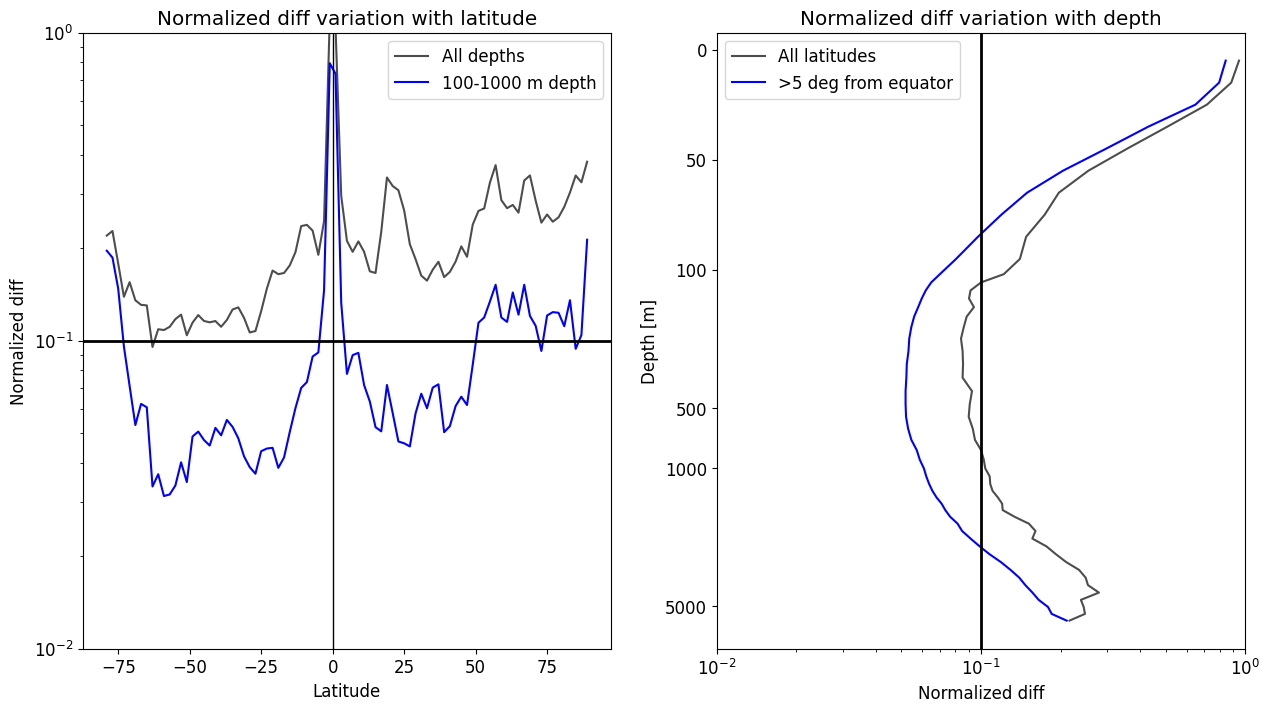

In [25]:
# plot normalized difference, binned by latitude and by depth
fig,axs = plt.subplots(1,2,figsize=(15,8))
curr_ax = axs[0]            
curr_ax.plot(lat_bin_centers,diff_norm_lat,color=(0.3,0.3,0.3),label='All depths')
curr_ax.plot(lat_bin_centers,diff_norm_lat_moremask,color='blue',label='100-1000 m depth')
curr_ax.set_ylim(0.01,1)
curr_ax.set_yscale('log')
curr_ax.axhline(y=0.1,color='black',lw=2)
curr_ax.axvline(x=0,color='black',lw=1)
curr_ax.set_xlabel('Latitude')
curr_ax.set_ylabel('Normalized diff')
curr_ax.set_title('Normalized diff variation with latitude')
curr_ax.legend()
curr_ax = axs[1]
curr_ax.plot(diff_norm_depth,-ds_grid.Z,color=(0.3,0.3,0.3),label='All latitudes')
curr_ax.plot(diff_norm_depth_moremask,-ds_grid.Z,color='blue',label='>5 deg from equator')
# Note: in older versions of Matplotlib
# may need to use linthreshy instead of linthresh
curr_ax.set_yscale('symlog',linthresh=100)
curr_ax.set_ylim(curr_ax.get_ylim()[::-1])
curr_ax.set_yticks([0,50,100,500,1000,5000])
curr_ax.set_yticklabels(['0','50','100','500','1000','5000'])
curr_ax.set_xlim(0.01,1)
curr_ax.set_xscale('log')
curr_ax.axvline(x=0.1,color='black',lw=2)
curr_ax.set_xlabel('Normalized diff')
curr_ax.set_ylabel('Depth [m]')
curr_ax.set_title('Normalized diff variation with depth')
curr_ax.legend()

plt.show()

From the above plots, we can see that for areas in the 100-1000 m depth range, more than 5 degrees from the equator and in low-to-mid latitudes, velocities are overwhelmingly geostrophic. Outside of these areas, geostrophy is less predictive of velocity. The bin-averaged normalized differences show the loss of geostrophic balance at the equator, near the ocean surface, and in the deep ocean.

Before we finish, you can use the code below to save the binned normalized differences plotted above. This will be useful in the next tutorial.

In [26]:
# save norm diff bin-averaged values (in numpy .npz format) for future use
diff_norm_inbins_filename = "diff_norm_geostr_bal.npz"
np.savez(diff_norm_inbins_filename,lat_bin_bounds=lat_bin_bounds,\
                                   diff_norm_lat=diff_norm_lat,\
                                   diff_norm_lat_moremask=diff_norm_lat_moremask,\
                                   depth_bin_bounds=depth_bin_bounds,\
                                   diff_norm_depth=diff_norm_depth,\
                                   diff_norm_depth_moremask=diff_norm_depth_moremask)

## Questions

1. All of the mapping we just did was with monthly data for January 2000:
* Would our results be similar if we did everything again using  daily data for 1 January 2000?
* How do you think geostrophic balance on daily timescales compares with monthly timescales?
* Why might they be different?

2. ...

## References

Gill, A.E. (1982). ***Atmosphere-Ocean Dynamics***. Academic Press, Elsevier.

Kundu, P.K. and Cohen, I.M. (2008). ***Fluid Mechanics*** (4th ed.). Elsevier.

Vallis, G.K. (2006). ***Atmospheric and Oceanic Fluid Dynamics***. Cambridge University Press.